## Stock price prediciton based on historical data, to utilise non deterministic solutions to train or learn what is going on in order to make predicitons. Can be for a single point in time or for a set of future time points.

### Features that are generally helpful in prediction are:-
#### Correlated Assets:- external factors like fiscal, monetary policy, competitors, clients, global economy, geopolitical situation, access to capital. So stock price will be correalted to other things like commodities, FX, broad based indices or fixed income security
#### Technical indicators:- momentum, MA, EMA
#### Fundamental analysis:- ROE, P/E, any news that will have effect on sentiments

### We will try to predict microsoft stock price using both arima models and deep learning model (LSTM)

In [26]:
import pandas as pd
import numpy as np

In [27]:
# ignoring warnings (you can remove it)
import warnings
warnings.filterwarnings('ignore')

In [28]:
#loading package for data reader from finance and yahoo
import pandas_datareader.data as web

In [29]:
stock_ticker = ['MSFT', 'IBM', 'GOOGL']
currency_ticker = ['DEXJPUS', 'DEXUSUK']
index_ticker = ['SP500', 'DJIA', 'VIXCLS']
stock_data = web.DataReader(stock_ticker, 'yahoo')
currency_data = web.DataReader(currency_ticker, 'fred')
index_data = web.DataReader(index_ticker, 'fred')

In [30]:
"""We will compute weekly returns, so lag will be of 5 days, curently we have daily data
    To calculate returns, we will be using logarthmic returns.
    Independent variables will be correalted assets, currencies and index data.
    Also, assume the microsoft shares also depend upon it's own return with different lags
    like 5-day, 15-day, 30-day and 60-day"""
return_period = 5
Y = np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(return_period).shift(-return_period) #we asign the returns to previous dates (It is done because we are doing regression of current values of Microsoft with lagged values of independent values)
Y.name = Y.name[-1] + '_Pred'

In [31]:
X1 = np.log(stock_data.loc[:, ('Adj Close', ('GOOGL', 'IBM'))]).diff(return_period)
X1.columns = X1.columns.droplevel()
X2 = np.log(currency_data).diff(return_period)
X3 = np.log(index_data).diff(return_period)
"""Microsoft lagged values"""
X4 = pd.concat([np.log(stock_data.loc[:, ('Adj Close', 'MSFT')]).diff(i) for i in [return_period, return_period*3, return_period*6, return_period*12]], axis=1).dropna()
X4.columns = ['MSFT_DT', 'MSFT_3DT', 'MSFT_6DT','MSFT_12DT']

In [32]:
X = pd.concat([X1, X2, X3, X4], axis=1)

In [33]:
"""Note that values for Y variables will be the next future values
    while values for X will be current, it happend because we use .shift(-return_period)
    during forming the microsoft Y (dependent) data,
    Final data at a interval of 5
    Dataset contains lagged series of correlated shocks, currencies and index.
    It also contains lagged historical returns of MSFT itself."""
dataset = pd.concat([Y,X], axis=1).dropna()
Y = dataset.loc[:,Y.name]
X = dataset.loc[:, X.columns]

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

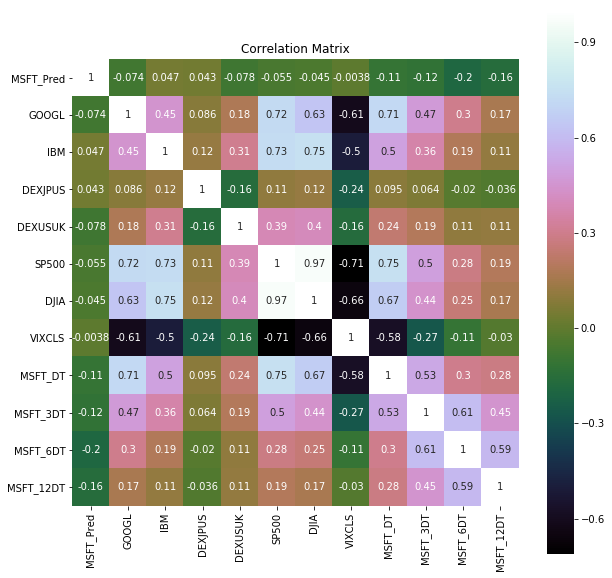

In [35]:
"""Exploratory data analysis"""
correlation = dataset.corr()
plt.figure(figsize=(10,10))
plt.title("Correlation Matrix")
sns.heatmap(correlation, vmax=1, square=True, annot=True, cmap='cubehelix')

<Figure size 720x720 with 0 Axes>

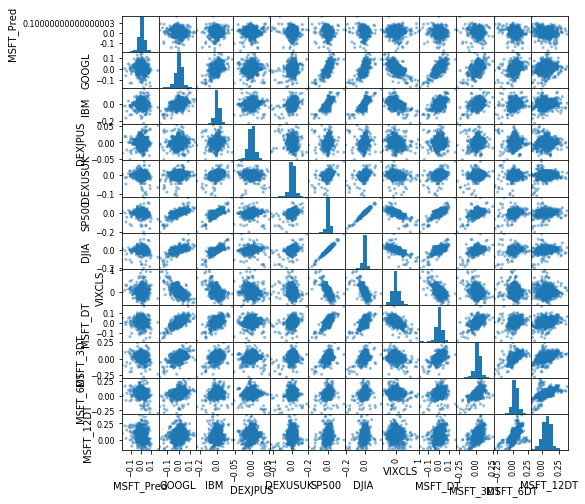

In [36]:
plt.figure(figsize=(10,10))
pd.plotting.scatter_matrix(dataset, figsize=(8,8))
plt.show()
#Not much relation of predicted variable with anything apart from some linear realtionship with its lagged values

In [37]:
"""Time Series analsysis"""
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

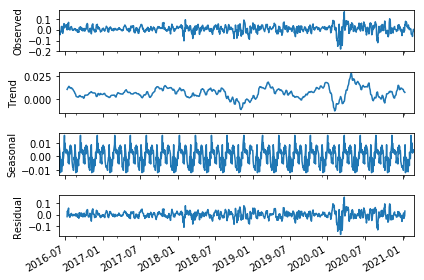

In [38]:
"""Decompose time series into seasonal and trend component"""
res = sm.tsa.seasonal_decompose(Y, freq=52)
fig = res.plot()
plt.show()

In [39]:
"""
Residual is relatively small across the entire time series, trend component will come up in constant. 
"""

'\nResidual is relatively small across the entire time series, trend component will come up in constant. \n'

In [40]:
"""Data Preparation involves data processing, data cleaning, 
   looking at feature importance and performing feature reduction
   Data that we have right now is relatively clean and do not require feature processing
   as already small variables are considered so we will keep them all"""

'Data Preparation involves data processing, data cleaning, \n   looking at feature importance and performing feature reduction\n   Data that we have right now is relatively clean and do not require feature processing\n   as already small variables are considered so we will keep them all'

## In time series data, sequence of data is very important. So do not distribute the data into training and test data randomely but select an arbitrary split point in ordered list of observations. 

In [41]:
"""because data is sequenced data we do not use train test split,
   simple split like below but this way we will have test data fix"""
validation_size = 0.2
train_size = int(len(X)* (1 - validation_size))
x_train, x_test = X[0:train_size], X[train_size:len(X)]
y_train, y_test = Y[0:train_size], Y[train_size:len(X)]

## Will use all kind of supervised regression, evaluation metric will be RMSE. Will use 10 fold cross validation to remove any inherent randomness in some of the models and CV process.

In [42]:
from sklearn.linear_model import LinearRegression, Lasso, ElasticNet

from sklearn.tree import DecisionTreeRegressor

from sklearn.svm import SVR

from sklearn.neighbors import KNeighborsRegressor

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor, AdaBoostRegressor

from sklearn.neural_network import MLPRegressor

In [43]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV

from sklearn.metrics import mean_squared_error

from sklearn.feature_selection import chi2, SelectKBest, f_regression

In [44]:
models = {
    'LR': LinearRegression(),
    'LASSO': Lasso(),
    'EN': ElasticNet(),
    'DT': DecisionTreeRegressor(),  #Classifiation and Regression Tree
    'SVR': SVR(),
    'KNR': KNeighborsRegressor(),
    'RFR': RandomForestRegressor(),
    'GFR': GradientBoostingRegressor(),
    'ETR': ExtraTreesRegressor(),
    'ADR': AdaBoostRegressor(),
    'ML_R': MLPRegressor()
}

In [45]:
seed = 10
num_folds = 10
scoring = 'neg_mean_squared_error'

In [46]:
names = []
kfold_results = []
train_results = []
test_results = []
for name, model in models.items():
    names.append(name)
    Kfold = KFold(n_splits=num_folds, random_state=seed)
    cv_results = -1*cross_val_score(model, x_train, y_train, cv=Kfold, scoring=scoring)
    kfold_results.append(cv_results)
    res = model.fit(x_train, y_train)
    train_results.append(mean_squared_error(res.predict(x_train), y_train))
    test_results.append(mean_squared_error(res.predict(x_test), y_test))

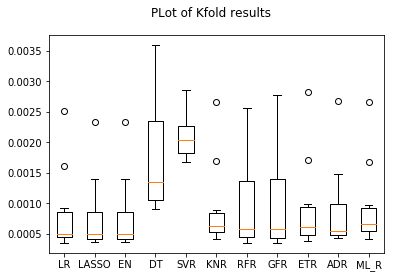

'As linear regresor perfoms best, it shows that there is a linear relation \n   between dependent variables and independent variable'

In [47]:
#plotting cross validation set errors
fig = plt.figure()
fig.suptitle("PLot of Kfold results")
ax = fig.add_subplot(111)
plt.boxplot(kfold_results)
ax.set_xticklabels(names)
plt.show()
"""As linear regresor perfoms best, it shows that there is a linear relation 
   between dependent variables and independent variable"""

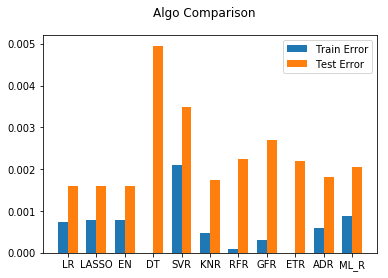

In [48]:
#Plotting training and test errors
fig = plt.figure()
ind = np.arange(len(names))
width = 0.35

fig.suptitle("Algo Comparison")
plt.bar(ind - width/2, train_results, width=width, label='Train Error')
plt.bar(ind + width/2, test_results, width=width, label= 'Test Error')
plt.legend()
ax = fig.add_subplot(111)
ax.set_xticks(ind)
ax.set_xticklabels(names)
plt.show()

## Using time Series model (ARIMA)

In [49]:
"""We will now use time series models,
   Models that we have used till now also had time series component in time delay approach
   in form of lagged variables,
   for time series models we do not need lagged variables, so we will remove them.
   """
x_train_arima = x_train.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]
x_test_arima = x_test.loc[:, ['GOOGL', 'IBM', 'DEXJPUS', 'SP500', 'DJIA', 'VIXCLS']]

tr_len = len(x_train_arima)
te_len = len(x_test_arima)
to_len = len(X)

In [50]:
model_arima = ARIMA(endog=y_train, exog=x_train_arima, order=[1,0,1])
model_fit = model_arima.fit()

In [51]:
train_error_arima = mean_squared_error(y_train, model_fit.fittedvalues)
predicted = model_fit.predict(start=tr_len-1, end=to_len-1, exog=x_test_arima)[1:]
test_error_arima = mean_squared_error(y_test, predicted)
print(test_error_arima)

0.0018383679408509


## Using Neural Network (LSTM)

In [60]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.optimizers import SGD
from keras.wrappers.scikit_learn import KerasRegressor

In [82]:
#prepare dataset for LSTM mode
seq_len=2
y_train_lstm, y_test_lstm = np.array(y_train)[seq_len-1:], np.array(y_test)
x_train_lstm = np.zeros((x_train.shape[0]+1-seq_len, seq_len, x_train.shape[1]))
x_test_lstm = np.zeros((x_test.shape[0], seq_len, X.shape[1]))

In [89]:
x_train_lstm.shape

(895, 2, 11)

### keeping it incomplete, not worth it to deep down more

## Model Tuning and grid search for ARIMA

In [132]:
def evaluate_arima_model(arima_order):
    modelARIMA = ARIMA(endog=y_train, exog=x_train_arima, order=arima_order)
    fit = modelARIMA.fit()
    error = mean_squared_error(fit.fittedvalues, y_train[1:])
    return error

In [133]:
# evaluate arima values for different p, d, q values

def evaluate_model(p_values, d_values, q_values):
    best_score, best_cfg = float('inf'), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    mse = evaluate_arima_model(order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print(f'ARiMA Score for {order} is {mse}')
                except:
                    continue
    print(f'Best score is {best_score} and best order values are {order}')   
    
    

In [134]:
p_values = [0,1,2]
d_values = [0,1]
q_values = [0,1]
evaluate_model(p_values, d_values, q_values)

ARiMA Score for (0, 1, 0) is 0.000827366641465699
ARiMA Score for (0, 1, 1) is 0.0009645097970331029
ARiMA Score for (1, 1, 0) is 0.0009081443473740348
ARiMA Score for (1, 1, 1) is 0.0011486122623057219
ARiMA Score for (2, 1, 0) is 0.0009643280364400115
ARiMA Score for (2, 1, 1) is 0.0009490289483895565
Best score is 0.000827366641465699 and best order values are (2, 1, 1)


In [135]:
# results on the data set
arima_model = ARIMA(endog=y_train, exog=x_train_arima, order = [2,1,1])
fitted_model = arima_model.fit()

In [144]:
prediction = fitted_model.predict(start=tr_len-1, end= to_len-1, exog=x_test_arima)[1:]
mse = mean_squared_error(prediction, y_test)
print(mse)

0.0017749460248570861


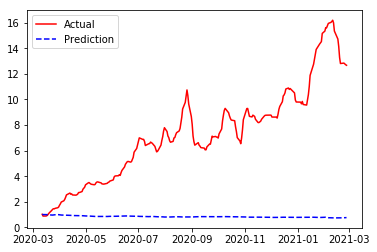

In [153]:
# plotting the curve
prediction.index = y_test.index
plt.plot(np.exp(y_test).cumprod(), 'r', label='Actual',) # cumprod is cumulative product

plt.plot(np.exp(prediction).cumprod(), 'b--', label='Prediction')
plt.legend()
plt.show()

In [ ]:
"""Some issues in final prediction,
   Final prediciton should be less volatile compared to actual series,
   models predict next day retursn compare to the returns till now,
   so do not predict several days in future given the current data. 
    """